In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations_JB import *
from proj1_helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
y, x, ids =  load_csv_data("train.csv")
y_test, x_test, ids_test = load_csv_data("test.csv")
data_list = full_data_processing(y,x,ids)

The cell below contains a function to dislay the histogram of a choosen feature

In [4]:
def histo(index_feature, y, x,bins):
    
    x_array = x[:,index_feature]
    x_mask = np.where(yb>0, True, False) # Transforming in a boolean mask
    
    print np.mean(x_array)
    print np.std(x_array)
    
    # Displaying the histogram for the whole data
    plt.hist(x_array,bins)
    plt.ylabel("Feature "+str(i))
    # Displaying the histogram for the data where y = 1
    plt.figure()
    plt.hist(x_array[x_mask],bins)
    # Displaying the histogram for the data where y = -1
    plt.figure()
    plt.hist(x_array[np.invert(x_mask)],bins)
    plt.show()

The cell below contains functions to split the data according to :
    - The value of PRI_jet_num (0,1,2 or 3)
    - The value of DER_Mass_MMC (-999 or well-defined value)

In [13]:
def splitting1(y,x,ids):
    for i in range(4):
        mask = (x[:,22] == i)
        yield y[mask], x[mask], ids[mask]
        
def splitting2(y,x,ids):
    feature0 = x[:,0]
    masks = [0,0]
    mask1 = np.where(feature0==-999,False,True)
    masks[0] = mask1
    masks[1] = np.invert(mask1)
    for mask in masks:
        yield y[mask], x[mask], ids[mask]
        
def full_splitting(y,x,ids):
    """
    Will yields in this order :
    split_id = 0) Data with a defined feature0 ans with PRI_jet_num = 0
    split_id = 1) Data with a defined feature0 ans with PRI_jet_num = 1
    split_id = 2) Data with a defined feature0 ans with PRI_jet_num = 2
    split_id = 3) Data with a defined feature0 ans with PRI_jet_num = 3
    split_id = 4) Data with an undefined feature0 ans with PRI_jet_num = 0
    split_id = 5) Data with an undefined feature0 ans with PRI_jet_num = 1
    split_id = 6) Data with an undefined feature0 ans with PRI_jet_num = 2
    split_id = 7) Data with an undefined feature0 ans with PRI_jet_num = 3
    """
    split_id = -1
    for y2,x2,ids2 in splitting2(y,x,ids):
        for y1,x1,ids1 in splitting1(y2,x2,ids2):
            split_id+=1
            yield y1,x1,ids1, split_id           

The cell below contains functions to prepare the data :
    - Remove some unrelevant features if needed
    - Transform the angle features in two features by applying sin() and cos()
    - Applying the absolute value to symetric features
    

In [6]:
def remove_features_jetnum(x,split_id):
    
    """
    Remove the useless features if the jet num feature is equal to 0 (--> split_id equal to 0 or 4)
    Remove the useless features if the jet num feature is equal to 1 (--> split_id equal to 1 or 5)
    """
    useless_features_index = []
    if split_id in [0,4]:
        useless_features_index = [4, 5, 6, 12,22, 23, 24, 25 , 26, 27, 28,29,33,34] 
    elif split_id in [1,5]:
        useless_features_index = [4, 5, 6, 12,22, 26, 27, 28,34]
    else:
        return x
    mask = np.ones(int(x.shape[1]), dtype=bool)
    mask[(useless_features_index)] = False
    return x[:,mask]

def angle_processing(x):
    
    angle_features = [15, 18, 20, 25, 28]
    new_x = np.zeros((x.shape[0], x.shape[1] + len(angle_features) ))
    
    for k in range(x.shape[1]):
        if k not in angle_features:
            new_x[:, k] = x[:, k]
        
    for idx, column in enumerate(angle_features): 
        
        new_x[:, column] = np.cos(x[:, column])
        new_x[:, x.shape[1] + idx] = np.sin(x[:, column])
    
    return new_x

def absolute_value(x,split_id):
    
    list0 = [10,11,13,14,16,18,19,20]
    list1 = [10,11,13,14,16,19,20,22,23,24,25]
    list2 = [14,15,17,18,20,24,25,27,28,30,31,32,33,34]
    list3 = [14,15,17,18,20,24,25,27,28,30,31,32,33,34]

    full_list = [list0, list1, list2, list3]
    
    list_ = full_list[split_id%4]

    for index in np.array(list_):
        x[:,index] = np.absolute(x[:,index])
    return x    

def full_data_processing(y,x,ids):
    data_list = []
    for y0,x0,ids0, split_id in full_splitting(y,x,ids):
        
        x0 = angle_processing(x0)
        x0 = remove_features_jetnum(x0,split_id)
        x0 = standardize(x0)
        x0 = absolute_value(x0,split_id)
    
        data_list.append([y0,x0,ids0])
        
    return data_list  

The cell below contains functions to do the regression

In [90]:
def regression(y_test, x_test, y_train, x_train,lambda_):
    
    # Here we can choose which method to use :
    
    w, train_loss = ridge_regression(y_train, x_train, lambda_)   
    #w, train_loss = least_squares_GD_adapt_step(y_train, x_train, 0*np.random.rand(int(x_train.shape[1])), 100, 0.00001,computeLoss = True);
    #w, train_loss = lasso_GD_adapt_step(y_train, x_train, 0*np.random.rand(int(x_train.shape[1])), 200, 0.000001, lambda_, computeLoss = True)
    test_loss = compute_loss(y_test, x_test, w)
    y_pred = predict_labels(w, x_test)
    
    return w, train_loss, test_loss, y_pred 

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

The cell below contains functions to train the model using K-Fold Cross-Validation

In [98]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_split(y,x,k_indices):
    
    for indices_list in k_indices:
        mask = np.ones(y.shape[0],dtype=bool)
        mask[indices_list] = False
        
        yield y[mask], standardize(x[mask]), y[np.invert(mask)], standardize(x[np.invert(mask)])


def Kfold_regression(y, x, k,degree,lambda_):
    
    seed = 1
    k_indices = build_k_indices(y, k, seed)
    
    train_loss_list = []
    test_loss_list = []
    score_list = []
    
    for y_train, x_train, y_test, x_test, in K_split(y,x,k_indices):
        x_train_poly = build_poly(x_train,degree)
        x_test_poly = build_poly(x_test,degree)
        w, train_loss, test_loss, y_pred = regression(y_test, x_test_poly, y_train, x_train_poly,lambda_)
        train_loss_list+=[train_loss]
        test_loss_list+=[test_loss]
        score_list+=[np.mean(y_pred == y_test)]
        
    return train_loss_list, test_loss_list,score_list  

The cell below contain a function to test the 2 parameters : the degree and lambda_

Degree = 3 and Lambda = 1e-08, Score = 0.7942348349325093
Degree = 4 and Lambda = 1e-08, Score = 0.7981650132812922
Degree = 5 and Lambda = 1e-08, Score = 0.8006721960210332
Degree = 6 and Lambda = 1e-08, Score = 0.8017970401691333
Degree = 7 and Lambda = 1e-08, Score = 0.8029489889955005
Degree = 8 and Lambda = 1e-08, Score = 0.8046023743698162
Degree = 9 and Lambda = 1e-08, Score = 0.8043855369436765
Degree = 10 and Lambda = 1e-08, Score = 0.8027592562476283
Degree = 11 and Lambda = 1e-08, Score = 0.8049682875264271
Degree = 12 and Lambda = 1e-08, Score = 0.7716566379357076
Degree = 13 and Lambda = 1e-08, Score = 0.7490648885997723
Degree = 14 and Lambda = 1e-08, Score = 0.70089987531848
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.7945736434108528
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.7985173740987693
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.8009296904645741
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.80247465712582
Degree 

Degree = 7 and Lambda = 0.001, Score = 0.7968368840461864
Degree = 8 and Lambda = 0.001, Score = 0.8050631539003632
Degree = 9 and Lambda = 0.001, Score = 0.8049276305090259
Degree = 10 and Lambda = 0.001, Score = 0.7704098227354041
Degree = 11 and Lambda = 0.001, Score = 0.8065403588659402
Degree = 12 and Lambda = 0.001, Score = 0.8077600693879764
Degree = 13 and Lambda = 0.001, Score = 0.8058491895701199
Degree = 14 and Lambda = 0.001, Score = 0.8056323521439802
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.794207730254242
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.7976906814116117
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.799154334038055
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.7990188106467175
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.8026643898736922
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.8050631539003631
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.8046836884046188
Degree = 10 and

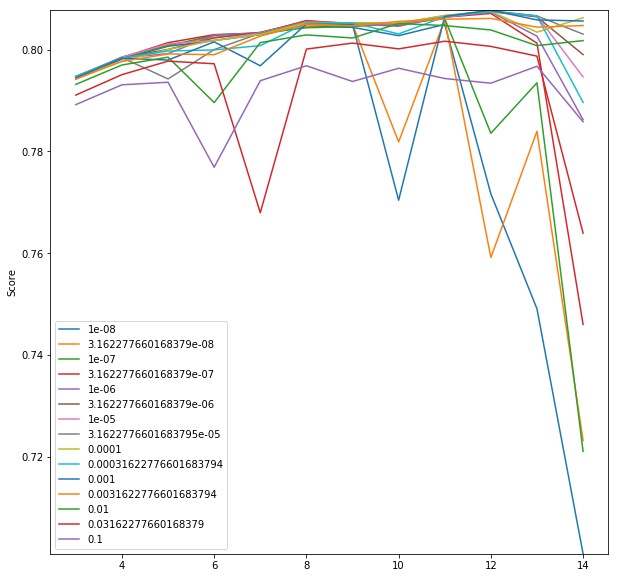

Degree = 3 and Lambda = 1e-08, Score = 0.755494584012118
Degree = 4 and Lambda = 1e-08, Score = 0.7659693046386007
Degree = 5 and Lambda = 1e-08, Score = 0.7688273457372317
Degree = 6 and Lambda = 1e-08, Score = 0.7723856069050273
Degree = 7 and Lambda = 1e-08, Score = 0.7806167652690846
Degree = 8 and Lambda = 1e-08, Score = 0.7884335076738402
Degree = 9 and Lambda = 1e-08, Score = 0.7914344508274028
Degree = 10 and Lambda = 1e-08, Score = 0.7909057132241561
Degree = 11 and Lambda = 1e-08, Score = 0.79219183171854
Degree = 12 and Lambda = 1e-08, Score = 0.7563948669581869
Degree = 13 and Lambda = 1e-08, Score = 0.7076795564320215
Degree = 14 and Lambda = 1e-08, Score = 0.6928891937466061
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.7554802938066251
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.7658692732001485
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.7689416673811769
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.7725285089599588
Degree

Degree = 7 and Lambda = 0.001, Score = 0.7809883106119065
Degree = 8 and Lambda = 0.001, Score = 0.7889336648661008
Degree = 9 and Lambda = 0.001, Score = 0.792091800280088
Degree = 10 and Lambda = 0.001, Score = 0.7919060276086771
Degree = 11 and Lambda = 0.001, Score = 0.7926776987053074
Degree = 12 and Lambda = 0.001, Score = 0.7950212924061848
Degree = 13 and Lambda = 0.001, Score = 0.7018634427963074
Degree = 14 and Lambda = 0.001, Score = 0.788319186029895
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.7552373603132413
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.7657978221726829
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.7690702792306153
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.7719283203292463
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.7804167023921805
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.7882763154134157
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.7910914858955671
Degree = 10 and

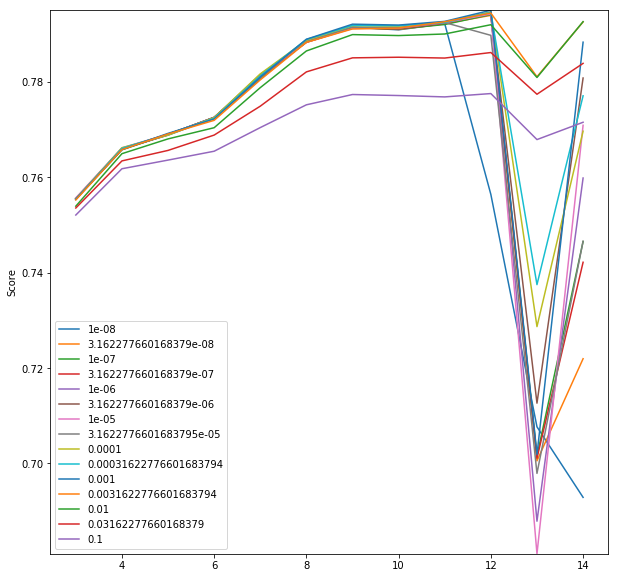

Degree = 3 and Lambda = 1e-08, Score = 0.7936909581646424
Degree = 4 and Lambda = 1e-08, Score = 0.8026948380566802
Degree = 5 and Lambda = 1e-08, Score = 0.8051197705802968
Degree = 6 and Lambda = 1e-08, Score = 0.8077555668016195
Degree = 7 and Lambda = 1e-08, Score = 0.8185307017543858
Degree = 8 and Lambda = 1e-08, Score = 0.826016363022942
Degree = 9 and Lambda = 1e-08, Score = 0.8277876180836707
Degree = 10 and Lambda = 1e-08, Score = 0.8272815452091767
Degree = 11 and Lambda = 1e-08, Score = 0.8290528002699055
Degree = 12 and Lambda = 1e-08, Score = 0.8303812415654521
Degree = 13 and Lambda = 1e-08, Score = 0.8279563090418353
Degree = 14 and Lambda = 1e-08, Score = 0.7916244939271255
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.7936698717948718
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.8028002699055331
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.8049932523616734
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.8076501349527665
Degr

Degree = 7 and Lambda = 0.001, Score = 0.8186572199730092
Degree = 8 and Lambda = 0.001, Score = 0.8256578947368421
Degree = 9 and Lambda = 0.001, Score = 0.828019568151147
Degree = 10 and Lambda = 0.001, Score = 0.8285467273954117
Degree = 11 and Lambda = 0.001, Score = 0.8286099865047234
Degree = 12 and Lambda = 0.001, Score = 0.8311825236167342
Degree = 13 and Lambda = 0.001, Score = 0.8059632253711202
Degree = 14 and Lambda = 0.001, Score = 0.8306553643724697
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.7935222672064778
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.8037280701754385
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.8058788798920378
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.8093370445344129
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.8181511470985156
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.8253415991902834
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.8268598178137653
Degree = 10 an

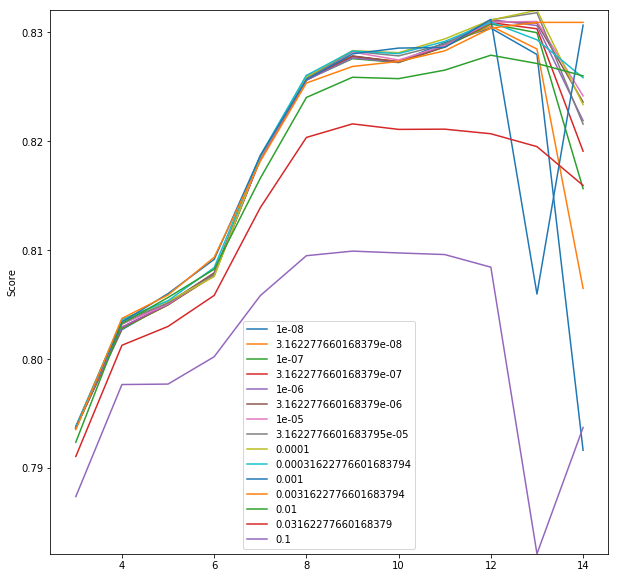

Degree = 3 and Lambda = 1e-08, Score = 0.780388743835219
Degree = 4 and Lambda = 1e-08, Score = 0.792815008219708
Degree = 5 and Lambda = 1e-08, Score = 0.7958611352867228
Degree = 6 and Lambda = 1e-08, Score = 0.7958611352867226
Degree = 7 and Lambda = 1e-08, Score = 0.8041775456919061
Degree = 8 and Lambda = 1e-08, Score = 0.8150082197079586
Degree = 9 and Lambda = 1e-08, Score = 0.8199400444831254
Degree = 10 and Lambda = 1e-08, Score = 0.8191664249105503
Degree = 11 and Lambda = 1e-08, Score = 0.8183928053379751
Degree = 12 and Lambda = 1e-08, Score = 0.8238564935692874
Degree = 13 and Lambda = 1e-08, Score = 0.7875447248815396
Degree = 14 and Lambda = 1e-08, Score = 0.7429648970118944
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.7803403926119331
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.7931051155594236
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.7957644328401509
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.7958611352867226
Degre

Degree = 7 and Lambda = 0.001, Score = 0.8040324920220482
Degree = 8 and Lambda = 0.001, Score = 0.8158301905038198
Degree = 9 and Lambda = 0.001, Score = 0.8192631273571221
Degree = 10 and Lambda = 0.001, Score = 0.820375205492699
Degree = 11 and Lambda = 0.001, Score = 0.8223092544241369
Degree = 12 and Lambda = 0.001, Score = 0.8257905425007254
Degree = 13 and Lambda = 0.001, Score = 0.8268059181897303
Degree = 14 and Lambda = 0.001, Score = 0.8246784643651485
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.7809206072913645
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.7932985204525674
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.7959094865100087
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.7954259742771491
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.8025819553234697
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.8129291171066629
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.8183928053379751
Degree = 10 an

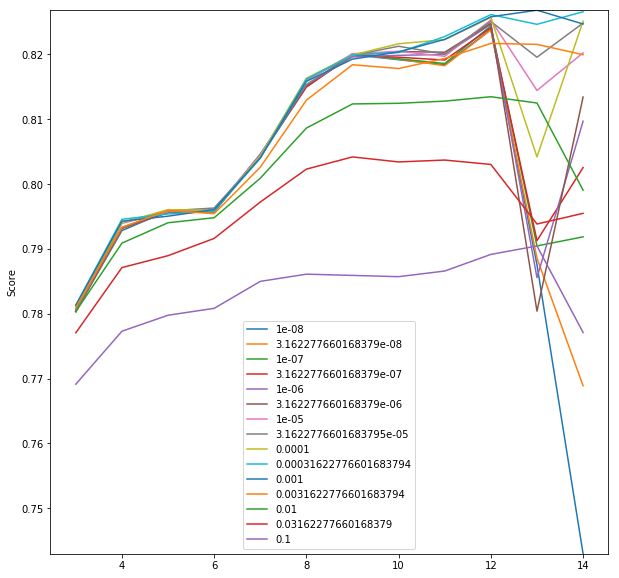

Degree = 3 and Lambda = 1e-08, Score = 0.945363350945708
Degree = 4 and Lambda = 1e-08, Score = 0.9475840416570946
Degree = 5 and Lambda = 1e-08, Score = 0.947086300635577
Degree = 6 and Lambda = 1e-08, Score = 0.9475840416570946
Degree = 7 and Lambda = 1e-08, Score = 0.9470480128646911
Degree = 8 and Lambda = 1e-08, Score = 0.9475074661153227
Degree = 9 and Lambda = 1e-08, Score = 0.9320392066773873
Degree = 10 and Lambda = 1e-08, Score = 0.9458993797381116
Degree = 11 and Lambda = 1e-08, Score = 0.9325369476989049
Degree = 12 and Lambda = 1e-08, Score = 0.8199709012941266
Degree = 13 and Lambda = 1e-08, Score = 0.8405697220307834
Degree = 14 and Lambda = 1e-08, Score = 0.7603951297955432
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.9458993797381118
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.9484646603874721
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.949000689179876
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.948847538096332
Degree 

Degree = 7 and Lambda = 0.001, Score = 0.9484646603874721
Degree = 8 and Lambda = 0.001, Score = 0.9486943870127882
Degree = 9 and Lambda = 0.001, Score = 0.9491921280343057
Degree = 10 and Lambda = 0.001, Score = 0.9477754805115247
Degree = 11 and Lambda = 0.001, Score = 0.9491155524925339
Degree = 12 and Lambda = 0.001, Score = 0.9336472930545984
Degree = 13 and Lambda = 0.001, Score = 0.9265257676698062
Degree = 14 and Lambda = 0.001, Score = 0.8324527146029559
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.9461291063634275
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.9479669193659546
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.948847538096332
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.9483880848457003
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.9483497970748145
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.948656099241902
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.9491155524925339
Degree = 10 and

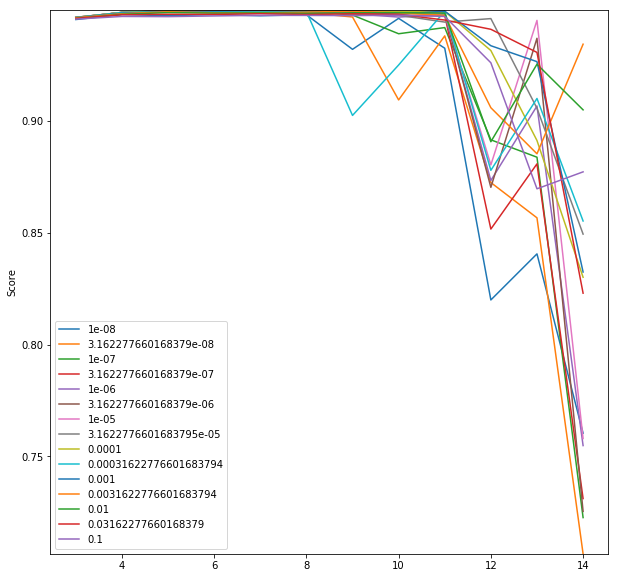

Degree = 3 and Lambda = 1e-08, Score = 0.9105820105820106
Degree = 4 and Lambda = 1e-08, Score = 0.9130952380952383
Degree = 5 and Lambda = 1e-08, Score = 0.9133597883597885
Degree = 6 and Lambda = 1e-08, Score = 0.9133597883597885
Degree = 7 and Lambda = 1e-08, Score = 0.9145502645502647
Degree = 8 and Lambda = 1e-08, Score = 0.9149470899470901
Degree = 9 and Lambda = 1e-08, Score = 0.9108465608465609
Degree = 10 and Lambda = 1e-08, Score = 0.9043650793650794
Degree = 11 and Lambda = 1e-08, Score = 0.8982804232804233
Degree = 12 and Lambda = 1e-08, Score = 0.8988095238095238
Degree = 13 and Lambda = 1e-08, Score = 0.8850529100529102
Degree = 14 and Lambda = 1e-08, Score = 0.8546296296296297
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.9149470899470901
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.9174603174603176
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.9175925925925927
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.9161375661375663
Deg

Degree = 7 and Lambda = 0.001, Score = 0.9179894179894181
Degree = 8 and Lambda = 0.001, Score = 0.9174603174603176
Degree = 9 and Lambda = 0.001, Score = 0.9165343915343916
Degree = 10 and Lambda = 0.001, Score = 0.9141534391534392
Degree = 11 and Lambda = 0.001, Score = 0.915079365079365
Degree = 12 and Lambda = 0.001, Score = 0.9148148148148149
Degree = 13 and Lambda = 0.001, Score = 0.9158730158730161
Degree = 14 and Lambda = 0.001, Score = 0.9015873015873016
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.9150793650793653
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.9177248677248678
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.9181216931216932
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.9174603174603176
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.9177248677248678
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.9171957671957673
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.9160052910052912
Degree = 10 an

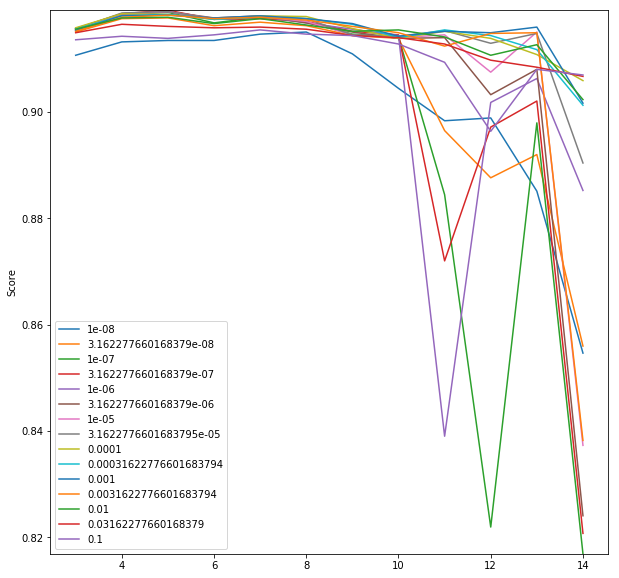

Degree = 3 and Lambda = 1e-08, Score = 0.8926151761517617
Degree = 4 and Lambda = 1e-08, Score = 0.8953252032520324
Degree = 5 and Lambda = 1e-08, Score = 0.8973577235772359
Degree = 6 and Lambda = 1e-08, Score = 0.8932926829268292
Degree = 7 and Lambda = 1e-08, Score = 0.8905826558265583
Degree = 8 and Lambda = 1e-08, Score = 0.8929539295392953
Degree = 9 and Lambda = 1e-08, Score = 0.8871951219512195
Degree = 10 and Lambda = 1e-08, Score = 0.877371273712737
Degree = 11 and Lambda = 1e-08, Score = 0.8590785907859079
Degree = 12 and Lambda = 1e-08, Score = 0.7997967479674797
Degree = 13 and Lambda = 1e-08, Score = 0.7974254742547426
Degree = 14 and Lambda = 1e-08, Score = 0.6897018970189701
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.8997289972899729
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.9004065040650406
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.9017615176151762
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.8990514905149051
Degr

Degree = 7 and Lambda = 0.001, Score = 0.8987127371273713
Degree = 8 and Lambda = 0.001, Score = 0.8987127371273713
Degree = 9 and Lambda = 0.001, Score = 0.9007452574525745
Degree = 10 and Lambda = 0.001, Score = 0.8960027100271003
Degree = 11 and Lambda = 0.001, Score = 0.8848238482384824
Degree = 12 and Lambda = 0.001, Score = 0.8871951219512195
Degree = 13 and Lambda = 0.001, Score = 0.8810975609756097
Degree = 14 and Lambda = 0.001, Score = 0.8113143631436315
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.9017615176151761
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.9014227642276423
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.9037940379403793
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.9000677506775068
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.8983739837398375
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.8970189701897019
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.8990514905149051
Degree = 10 a

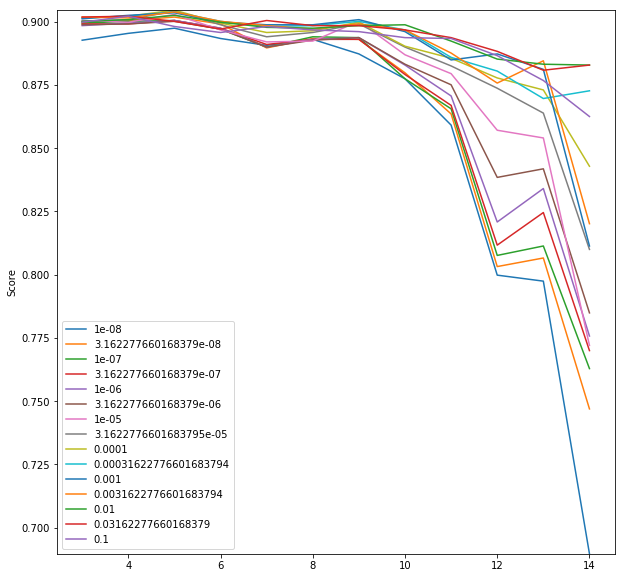

Degree = 3 and Lambda = 1e-08, Score = 0.9295392953929538
Degree = 4 and Lambda = 1e-08, Score = 0.9247967479674796
Degree = 5 and Lambda = 1e-08, Score = 0.9159891598915988
Degree = 6 and Lambda = 1e-08, Score = 0.9180216802168021
Degree = 7 and Lambda = 1e-08, Score = 0.899728997289973
Degree = 8 and Lambda = 1e-08, Score = 0.8848238482384824
Degree = 9 and Lambda = 1e-08, Score = 0.8895663956639566
Degree = 10 and Lambda = 1e-08, Score = 0.8441734417344172
Degree = 11 and Lambda = 1e-08, Score = 0.7601626016260162
Degree = 12 and Lambda = 1e-08, Score = 0.80420054200542
Degree = 13 and Lambda = 1e-08, Score = 0.7540650406504065
Degree = 14 and Lambda = 1e-08, Score = 0.6747967479674797
Degree = 3 and Lambda = 3.162277660168379e-08, Score = 0.9302168021680216
Degree = 4 and Lambda = 3.162277660168379e-08, Score = 0.9254742547425473
Degree = 5 and Lambda = 3.162277660168379e-08, Score = 0.9153116531165311
Degree = 6 and Lambda = 3.162277660168379e-08, Score = 0.9186991869918698
Degree

Degree = 7 and Lambda = 0.001, Score = 0.9180216802168021
Degree = 8 and Lambda = 0.001, Score = 0.907859078590786
Degree = 9 and Lambda = 0.001, Score = 0.9017615176151762
Degree = 10 and Lambda = 0.001, Score = 0.8787262872628726
Degree = 11 and Lambda = 0.001, Score = 0.8428184281842818
Degree = 12 and Lambda = 0.001, Score = 0.8489159891598915
Degree = 13 and Lambda = 0.001, Score = 0.8380758807588076
Degree = 14 and Lambda = 0.001, Score = 0.8326558265582656
Degree = 3 and Lambda = 0.0031622776601683794, Score = 0.9295392953929539
Degree = 4 and Lambda = 0.0031622776601683794, Score = 0.9254742547425474
Degree = 5 and Lambda = 0.0031622776601683794, Score = 0.9281842818428183
Degree = 6 and Lambda = 0.0031622776601683794, Score = 0.9247967479674796
Degree = 7 and Lambda = 0.0031622776601683794, Score = 0.9220867208672087
Degree = 8 and Lambda = 0.0031622776601683794, Score = 0.9153116531165312
Degree = 9 and Lambda = 0.0031622776601683794, Score = 0.9126016260162602
Degree = 10 an

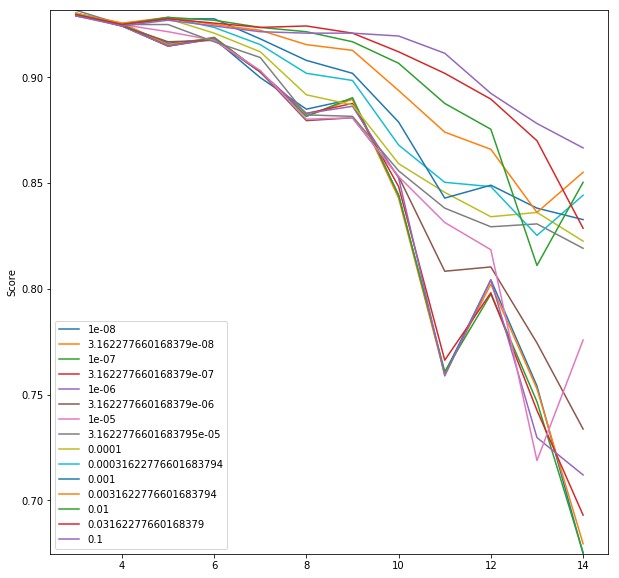

In [106]:
def param_test_simultane(y, x, k):
    
    lambda_list = np.logspace(-8, -1, 15)
    degree_list = np.arange(3,15)
    
    final_train_loss_list = np.zeros((len(degree_list),len(lambda_list)))
    final_test_loss_list = np.zeros((len(degree_list),len(lambda_list)))
    final_score_list = np.zeros((len(degree_list),len(lambda_list)))

    
    
    for i, lambda_ in enumerate(lambda_list):
        for j,degree in enumerate(degree_list):
            
            train_loss_list, test_loss_list,score_list = Kfold_regression(y, x,k,degree,lambda_)
            train_loss, test_loss, score = np.mean(train_loss_list), np.mean(test_loss_list), np.mean(score_list)
            final_train_loss_list[j,i]=train_loss
            final_test_loss_list[j,i]=test_loss
            final_score_list[j,i]=score
            
            print ("Degree = " + str(degree) + " and Lambda = " + str(lambda_) + ", Score = " + str(score))
    
        """
        plt.figure()
        plt.plot(degree_list,final_train_loss_list[:,i])
        plt.ylabel("Train Loss")
        plt.figure()
        plt.plot(degree_list,final_test_loss_list[:,i])
        plt.ylabel("Test Loss")
        plt.figure()
        plt.plot(degree_list,final_score_list[:,i], label = str(lambda_))
        plt.ylabel("Score for lambda = " + str(lambda_))
        plt.ylim(0.6, 1)
        plt.legend()
        plt.show()
        """

    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    for i, lambda_ in enumerate(lambda_list):
        plt.plot(degree_list, final_score_list[:,i], label = str(lambda_))
        plt.ylabel("Score")

    plt.ylim(np.min(final_score_list), np.max(final_score_list))
    plt.legend()
    plt.savefig("test" + str(i) + ".png")
    plt.show()
    
    return final_train_loss_list, final_test_loss_list, final_score_list

for i in range(8):
    param_test_simultane(data_list[i][0], data_list[i][1],6)

The cell below contain a function to make a csv file to upload it on Kaggle

In [107]:
def submission(deg_list, lambda_list,y, x, ids, y_test, x_test, ids_test):
    
    data_list_train = full_data_processing(y,x,ids)
    data_list_test = full_data_processing(y_test,x_test,ids_test)
    
    ids_final = np.array([])
    y_pred_final = np.array([])

    for i in range(len(data_list_train)):
        degree = deg_list[i]
        lambda_ = lambda_list[i]
        x_poly = build_poly(data_list_train[i][1], degree)
        x_poly_test = build_poly(data_list_test[i][1], degree)
        
        w, train_loss, test_loss, y_pred = regression(data_list_test[i][0], x_poly_test, data_list_train[i][0], x_poly, lambda_)
    
        ids_final = np.append(ids_final, data_list_test[i][2])
        y_pred_final = np.append(y_pred_final, y_pred)
        
    create_csv_submission(ids_final, y_pred_final, "prediction.csv")        

#deg_list = [12,12,12,12,8,4,5,4]
#lambda_list = [1e-05,1e-05,0.001,0.0001,1e-05,1e-05,0.0001,0.001]
deg_list = [12,12,12,13,5,5,5,3]
lambda_list = [3.1622776601683795e-05,0.001,1e-6,0.001,1e-5,1e-6,0.0001,3.1622776601683795e-05]
submission(deg_list,lambda_list,y, x, ids, y_test, x_test, ids_test)